In [1]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from sklearn.model_selection import train_test_split

# Reading the csv
titanic_df = pd.read_csv("/home/deploy/pramit/data/titanic/train.csv")
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [2]:
# Quick data transformation and cleaning ...
titanic_df["Sex"] = titanic_df["Sex"].astype('category')
titanic_df["Sex_Encoded"] = titanic_df["Sex"].cat.codes

titanic_df["Embarked"] = titanic_df["Embarked"].astype('category')
titanic_df["Embarked_Encoded"] = titanic_df["Embarked"].cat.codes
print(titanic_df.head(5))
titanic_df_clean = titanic_df.drop(['Ticket','Cabin', 'Name', 'Sex', 'Embarked'], axis=1)
# # Remove NaN values
titanic_df_clean = titanic_df_clean.dropna() 
print(titanic_df_clean.head(5))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Sex_Encoded  \
0      0         A/5 21171   7.2500   NaN        S            1   
1      0          PC 17599  71.2833   C85        C            0   
2      0  STON/O2. 3101282   7.9250   NaN        S            0   
3      0            113803  53.1000  C123        S  

In [3]:
y = titanic_df_clean['Survived']

In [4]:
data = titanic_df_clean.drop(['Survived'], axis=1)
data['label'] = y
print(data.head())
# Lets trying building an Interpretable Model
feature_labels = list(data.columns)
print(type(feature_labels[0]))
print(feature_labels)

   PassengerId  Pclass   Age  SibSp  Parch     Fare  Sex_Encoded  \
0            1       3  22.0      1      0   7.2500            1   
1            2       1  38.0      1      0  71.2833            0   
2            3       3  26.0      0      0   7.9250            0   
3            4       1  35.0      1      0  53.1000            0   
4            5       3  35.0      0      0   8.0500            1   

   Embarked_Encoded  label  
0                 2      0  
1                 0      1  
2                 2      1  
3                 2      1  
4                 2      0  
<type 'str'>
['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_Encoded', 'Embarked_Encoded', 'label']


In [5]:
# Split into train and test
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
Xtrain, Xtest, ytrain, ytest = train_test_split(data, y, test_size=0.20, random_state=0)
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)
#r_input_data = pandas2ri.py2ri(data)

(571, 9)
(143, 9)
(571,)
(143,)


In [6]:
as_factor = ro.r['as.factor']
s_apply = ro.r['sapply']
frame = ro.r['data.frame']
r_Xtrain = frame(s_apply(Xtrain, as_factor))
r_Xtest = frame(s_apply(Xtest, as_factor))
print(type(r_Xtrain))

<class 'rpy2.robjects.vectors.DataFrame'>


In [7]:
sbrl = importr('sbrl')

In [8]:
print(sbrl.sbrl.__dict__)

{'__rpackagename__': 'sbrl', '__rname__': 'sbrl', '_local_env': <rpy2.rinterface.SexpEnvironment - Python:0x7f665068db28 / R:0x4980578>, '_prm_translate': OrderedDict([('neg_sign', 'neg_sign'), ('minsupport_pos', 'minsupport_pos'), ('pos_sign', 'pos_sign'), ('iters', 'iters'), ('tdata', 'tdata'), ('nchain', 'nchain'), ('rule_minlen', 'rule_minlen'), ('eta', 'eta'), ('rule_maxlen', 'rule_maxlen'), ('minsupport_neg', 'minsupport_neg'), ('alpha', 'alpha'), ('lambda', 'lambda')])}


In [9]:
%prun
model = sbrl.sbrl(r_Xtrain, iters=50000, 
                  pos_sign=1, neg_sign=0, rule_minlen=1, 
                  rule_maxlen=4, minsupport_pos=0.10, minsupport_neg=0.10, eta=1.0, nchain=40)
print(model)

 Eclat

parameter specification:
 tidLists support minlen maxlen            target   ext
    FALSE     0.1      1      4 frequent itemsets FALSE

algorithmic control:
 sparse sort verbose
      7   -2    TRUE

Absolute minimum support count: 22 

create itemset ... 
set transactions ...[428 item(s), 226 transaction(s)] done [0.00s].
sorting and recoding items ... [12 item(s)] done [0.00s].
creating bit matrix ... [12 row(s), 226 column(s)] done [0.00s].
writing  ... [96 set(s)] done [0.00s].
Creating S4 object  ... done [0.00s].
Eclat

parameter specification:
 tidLists support minlen maxlen            target   ext
    FALSE     0.1      1      4 frequent itemsets FALSE

algorithmic control:
 sparse sort verbose
      7   -2    TRUE

Absolute minimum support count: 34 

create itemset ... 
set transactions ...[567 item(s), 345 transaction(s)] done [0.00s].
sorting and recoding items ... [10 item(s)] done [0.00s].
creating bit matrix ... [10 row(s), 345 column(s)] done [0.00s].
writing 

In [10]:
result_r_score = ro.r.predict(model, r_Xtest)

In [11]:
pandas_df = pandas2ri.ri2py_dataframe(result_r_score)
pandas_df.head()

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
0,0.569767,0.04918,0.6,0.927536,0.6,0.832536,0.6,0.6,0.6,0.6,...,0.6,0.6,0.832536,0.04918,0.569767,0.927536,0.832536,0.04918,0.832536,0.04918
1,0.430233,0.95082,0.4,0.072464,0.4,0.167464,0.4,0.4,0.4,0.4,...,0.4,0.4,0.167464,0.95082,0.430233,0.072464,0.167464,0.95082,0.167464,0.95082


In [12]:
#from sklearn.metrics import roc_auc_score
from sklearn import metrics
predicted_scores_prob = pd.DataFrame(pandas_df.values.T)
fpr, tpr, thresholds = metrics.roc_curve(ytest ,predicted_scores_prob[1], pos_label=1)

In [13]:
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.859671677215


In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
y_train = ytrain
y_test = ytest
x_train = Xtrain.drop(['label'], axis=1)
x_test = Xtest.drop(['label'], axis=1)
rf_model = RandomForestClassifier().fit(x_train, y_train)
rf_predict_score = pd.DataFrame(rf_model.predict_proba(x_test))
print(rf_predict_score).head()

     0    1
0  0.3  0.7
1  0.1  0.9
2  0.5  0.5
3  0.7  0.3
4  0.5  0.5


In [16]:
rf_predict_score[0].head()
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(y_test, rf_predict_score[1], pos_label=1)
rf_roc_auc = metrics.auc(rf_fpr, rf_tpr)
print(rf_roc_auc)

0.854133702532


In [17]:
fpr_list = [rf_fpr, fpr]
tpr_list = [rf_tpr, tpr]
roc_auc_list = [rf_roc_auc, roc_auc]
label_list = ['Random Forest', 'Decision Rules']

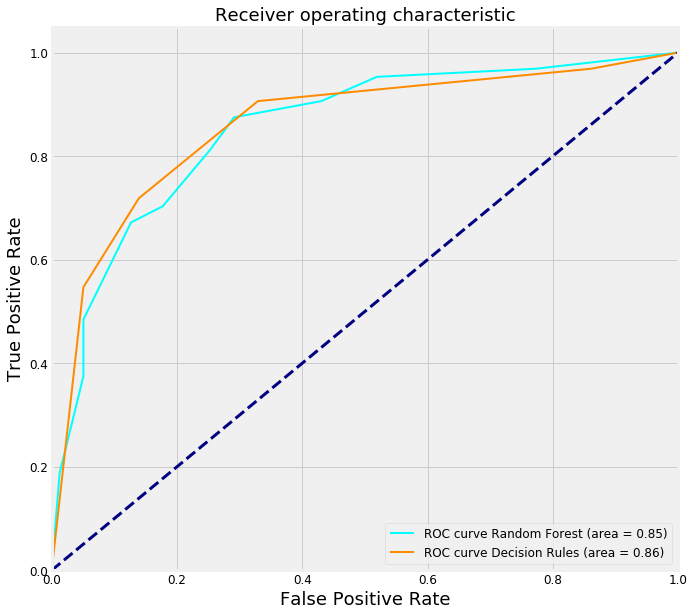

In [19]:
from itertools import cycle
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
plt.style.use(['fivethirtyeight'])
%matplotlib inline
plt.figure(figsize=(10,10))
#plt.rc('legend', size=10)
plt.rc('font', size=12)
lw = 2
colors = ['aqua', 'darkorange']
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], color=colors[i],
         lw=lw, label='ROC curve {0} (area = {1:0.2f})'.format(label_list[i], roc_auc_list[i]), )
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")

In [55]:
plt.style.available

[u'seaborn-darkgrid',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'_classic_test',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn',
 u'seaborn-dark-palette']

In [37]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

x_values = [1, 2, 3, 4, 5]
y_values = [6, 7, 2, 3, 6]
y_values2 = [3, 7, 2, 9, 6]
p = figure()
p.line(x=x_values, y=y_values2, line_color="blue")
p.line(x=x_values, y=y_values, line_color="pink")
show(p)

Loading BokehJS ...